#### Notebook for Exploring CKA applied to BERT

In [1]:
import torch
import torch.nn.utils.prune as prune
from torch_cka import CKA
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.utils.data import DataLoader
from bertviz import model_view, head_view

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Tokenize Dataset

Note that padding is being used based on the maxlen right now. This is a requirement to concat items into batches in PyTorch. Reduction was being used prior. 

TODO: Trim the max_len down to something more reasonable so there aren't a bunch of useless tokens.

In [2]:
# Setup chosen task and metric
task = "cola"
checkpoint = "bert-base-uncased"
dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task)

# Figure out dataset characteristics
max_len_train = len(max(dataset['train']['sentence'][:]))
max_len_val = len(max(dataset['validation']['sentence'][:]))
max_len_test = len(max(dataset['test']['sentence'][:]))
max_len = max(max_len_train, max_len_val, max_len_test)

# Tokenize Dataset
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
# preprocess function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', max_length=max_len)
encoded_dataset = dataset.map(preprocess_function, batched=True)

/tmp/ipykernel_229974/2933868654.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("glue", task)
/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is depreca

In [ ]:
# Collate function (not currently used)

#def collate_fn(batch):
#    input_ids = torch.stack([item['input_ids'] for item in batch])
#    attention_mask = torch.stack([item['attention_mask'] for item in batch])
#    #label = torch.stack([item['label'] for item in batch])
#    token_type_ids = torch.stack([item['token_type_ids'] for item in batch])
#    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}

In [3]:
# Convert to PyTorch dataloaders
batch_size = 16

tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
print(tokenized_dataset)

train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size)
val_loader = DataLoader(tokenized_dataset['validation'], batch_size=batch_size)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=1) # Has to be the case for bertviz

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1063
    })
})


If CUDA OOM is being thrown, try reducing the batch size

In [23]:
model_directory = 'bert_pruning_model'
num_labels=2
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device

# Import two models for comparison
#model1 = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, output_attentions=True)
model1 = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)
model2 = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)

model1 = model1.to(device)
model2 = model2.to(device)

# Choose layers to factor into CKA calculation
model1_names = [f"bert.encoder.layer.{i}.attention" for i in range(0, 12)]
model2_names = [s for s in model1_names] # Perform Copy

In [16]:
cka = CKA(model1, model2, model1_name="Model1", model2_name="Model2", model1_layers=model1_names, model2_layers=model2_names, device=device)
cka.compare(train_loader)
results = cka.export()

/home/andrew/school/grad/spring24/bert_pruning/PyTorch-Model-Compare/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 268/268 [00:46<00:00,  5.75it/s]


Show results of CKA calculation

{'model1_name': 'Model1', 'model2_name': 'Model2', 'CKA': tensor([[1.0000, 0.9657, 0.9383, 0.7981, 0.7835, 0.8066, 0.8246, 0.8440, 0.8044,
         0.4951, 0.2495, 0.1470],
        [0.9657, 1.0000, 0.9754, 0.8217, 0.8055, 0.8316, 0.8493, 0.8691, 0.8303,
         0.5143, 0.2594, 0.1527],
        [0.9383, 0.9755, 1.0000, 0.8068, 0.7877, 0.8178, 0.8391, 0.8638, 0.8311,
         0.5237, 0.2662, 0.1581],
        [0.7981, 0.8217, 0.8067, 1.0000, 0.9981, 0.9951, 0.9880, 0.9717, 0.8875,
         0.4811, 0.2143, 0.1212],
        [0.7835, 0.8055, 0.7877, 0.9981, 1.0000, 0.9968, 0.9897, 0.9729, 0.8879,
         0.4798, 0.2134, 0.1209],
        [0.8066, 0.8316, 0.8178, 0.9951, 0.9968, 1.0000, 0.9972, 0.9863, 0.9068,
         0.5007, 0.2277, 0.1307],
        [0.8246, 0.8492, 0.8391, 0.9880, 0.9897, 0.9972, 1.0000, 0.9949, 0.9223,
         0.5205, 0.2430, 0.1423],
        [0.8440, 0.8691, 0.8638, 0.9717, 0.9729, 0.9863, 0.9949, 1.0000, 0.9415,
         0.5535, 0.2728, 0.1673],
        [0.8043, 0.830

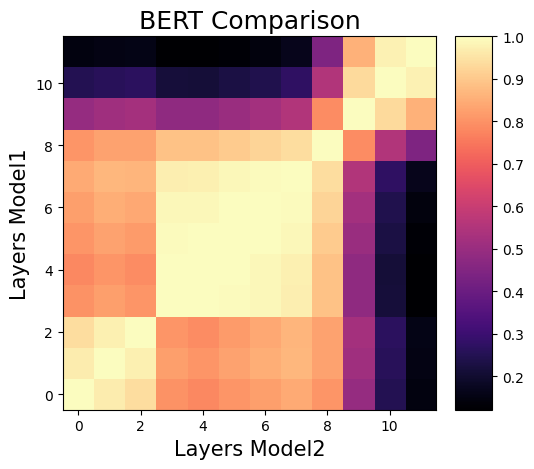

In [17]:
print(results)
cka.plot_results("plot", "BERT Comparison")

#### BertViz Exploration

Note that we ideally don't want to PAD to the 73rd dimension but we need to cherry pick sentences for bertviz to work properly

In [ ]:
# Set test environment
model1.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model1(**batch)
        break

batch = {k: v.to('cpu') for k,v in batch.items()}

# Get tokens from input
ids = batch['input_ids']
tokens = tokenizer.convert_ids_to_tokens(ids[0])

# Get attention masks from output
masks = outputs.attentions

#model_view(masks, tokens)
head_view(masks, tokens)

##### Exploring Pruning And CKA

In [4]:
# Calculate sparisty of the network
def calcSparsity(model):
    zeros = 0
    elements = 0

    for name, param in model.named_parameters():

        zero_count = torch.sum(param==0.0).item()
        zeros += zero_count

        element_count = param.numel()
        elements += element_count

    if(elements == 0):
        return 0

    return zeros / elements

# Note: The pruning strength is for the subset of the neurons that you want to prune (defined by the paramater list created in the build parameter list function #
def buildParameterList(model):
    parameters_to_prune = []
    parameter_names = []
    for name, module in model.named_modules():
        # Linear: Includes linear layers in attention head as well
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    return parameters_to_prune, parameter_names

# NOTE: Metric is defined globally
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # TODO: switch to torch?
    return metric.compute(predictions=predictions, references=labels)

def evaluateUnstructuredPruningOnBert(model_directory, dataset, tokenizer, pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], num_labels=2):

    pruning_results = []
    models = []

    # Try different pruning methods
    for p_strength in pruning_strength:

        # Load model
        test_model = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)
        # Don't move onto GPU because of VRAM concerns

        # Choose layers to prune
        pruning_params, _ = buildParameterList(test_model)

        if(p_strength > 0):

            # Perform global unstrcutured pruning
            prune.global_unstructured(
                pruning_params,
                pruning_method=prune.L1Unstructured,
                amount=p_strength
            )

            # Make pruning permenant
            for module,name in pruning_params:
                prune.remove(module, name)

        models.append(test_model)

        sparsity = calcSparsity(test_model)
        print(f"Pruning strength: {p_strength}, Sparsity: {sparsity}")

        # TODO: Evaluate Model
        # Create evaluator
        #evaluator = buildTrainer(test_model, dataset, tokenizer)
        # Evaluate performance on BERT 
        #results = evaluator.evaluate()
        #metric_res = results['eval_matthews_correlation']
        #pruning_results.append((sparsity, metric_res))
        
    return pruning_results, models

In [5]:
model_directory = 'bert_pruning_model'

# This needs ~ 16GB of RAM, probably best to do it on the CPU since it isn't computationally expensive
p_res, models = evaluateUnstructuredPruningOnBert(model_directory, encoded_dataset, tokenizer)

Pruning strength: 0, Sparsity: 0.0
Pruning strength: 0.1, Sparsity: 0.0781175271463504
Pruning strength: 0.2, Sparsity: 0.15623504515892755
Pruning strength: 0.3, Sparsity: 0.23435257230527795
Pruning strength: 0.4, Sparsity: 0.3124700903178551
Pruning strength: 0.5, Sparsity: 0.3905876174642055
Pruning strength: 0.6, Sparsity: 0.4687051446105559
Pruning strength: 0.7, Sparsity: 0.5468226626231331
Pruning strength: 0.8, Sparsity: 0.6249401897694835
Pruning strength: 0.9, Sparsity: 0.7030577077820607


/home/andrew/school/grad/spring24/bert_pruning/PyTorch-Model-Compare/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 535/535 [01:13<00:00,  7.24it/s]
| Comparing features |: 100%|██████████| 535/535 [01:15<00:00,  7.06it/s]
| Comparing features |: 100%|██████████| 535/535 [01:17<00:00,  6.88it/s]
| Comparing features |: 100%|██████████| 535/535 [01:18<00:00,  6.81it/s]
| Comparing features |: 100%|██████████| 535/535 [01:18<00:00,  6.78it/s]
| Comparing features |: 100%|██████████| 535/535 [01:15<00:00,  7.06it/s]
| Comparing features |: 100%|██████████| 535/535 [01:14<00:00,  7.17it/s]
| Comparing features |: 100%|██████████| 535/535 [01:14<00:00,  7.18it/s]
| Comparing features |: 100%|██████████| 535/535 [01:14<00:00,  7.14it/s]


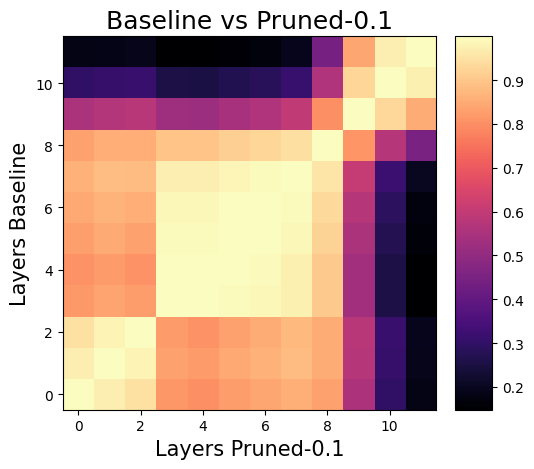

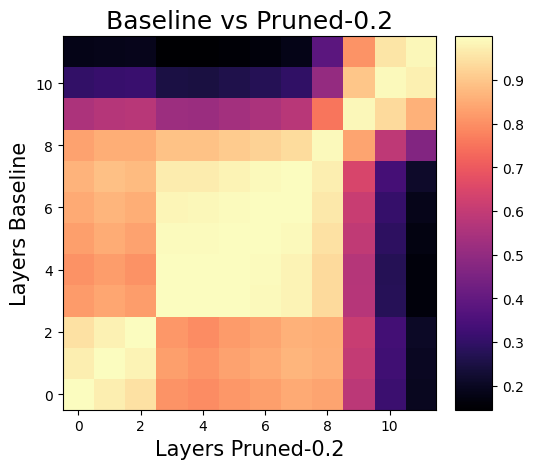

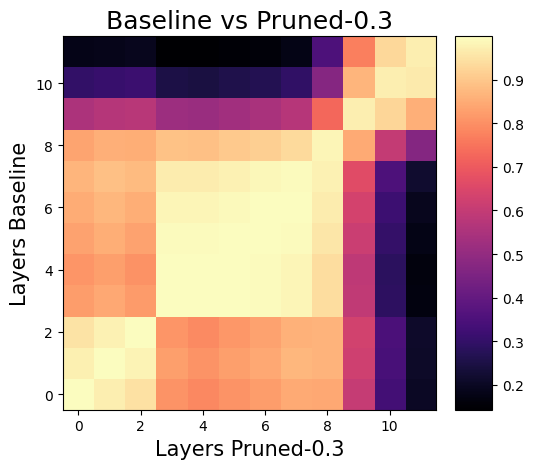

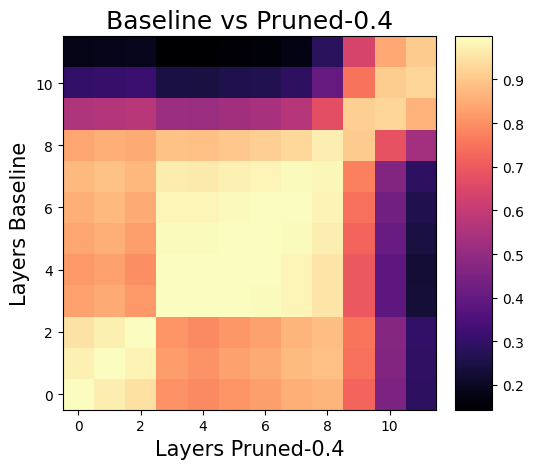

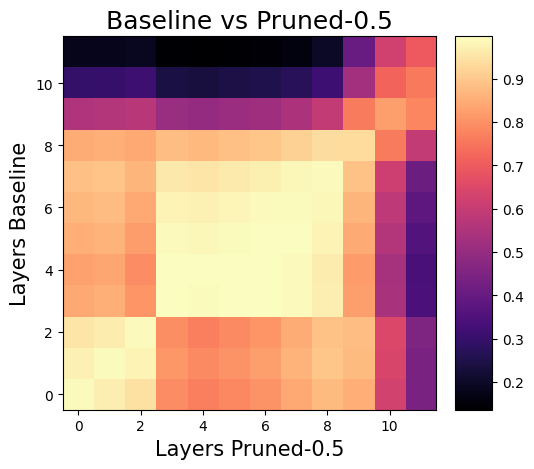

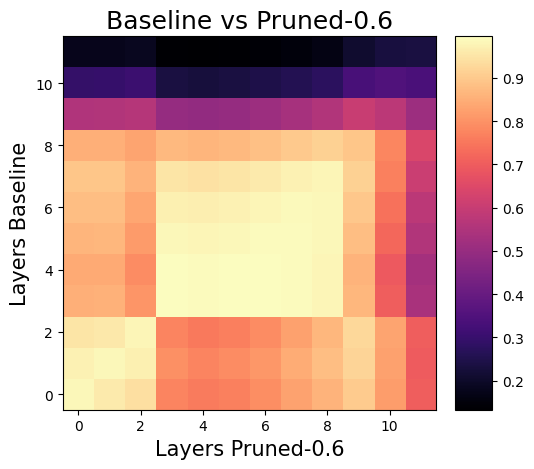

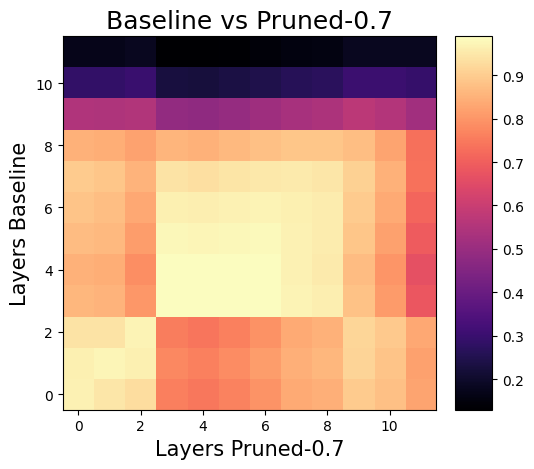

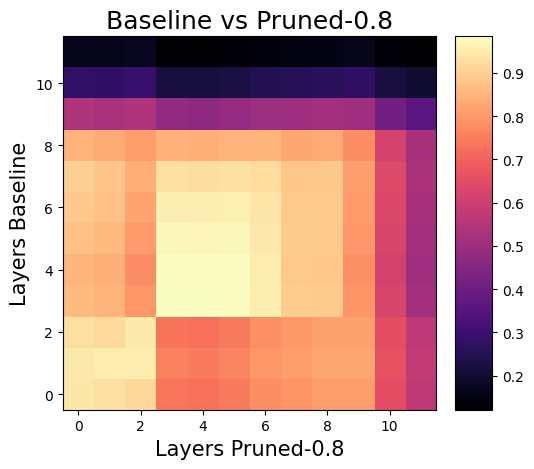

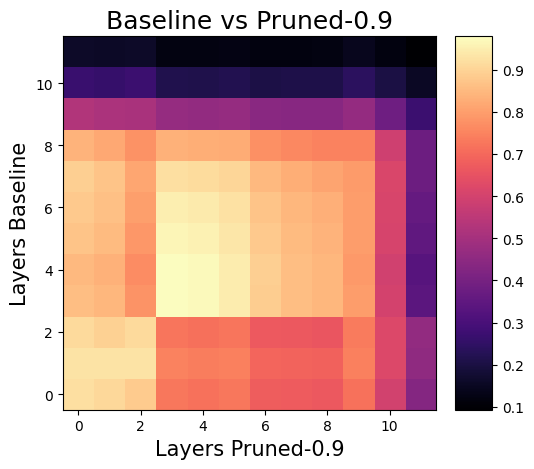

In [6]:
# Perform CKA Analysis on Pruned Models

device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Eventually define above

# Create Plot Directory
root_dir = os.path.dirname( os.getcwd() )
plot_dir = os.path.join(root_dir, 'plots')

# Create plot dir if it doesn't already exist
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

dirs = os.listdir(plot_dir)

if(dirs is None):
    curr_dir = os.path.join(plot_dir, "CKA_Run1")
else:
    curr_dir = os.path.join(plot_dir, f"CKA_Run{len(dirs)}")

# Create plot directory 
os.mkdir(curr_dir)

# Choose layers to factor into CKA calculation
model1_names = [f"bert.encoder.layer.{i}.attention" for i in range(0, 12)]
model2_names = [s for s in model1_names] # Perform Copy

length = len(models)

# Always compare against baseline
# Be careful to watch VRAM when running this
for i in range(1, length):

    model1_name = "Baseline"
    model2_name = f"Pruned-{pruning_strength[i]}"

    model1 = models[0] # Baseline
    model2 = models[i] # Pruned Model

    model1 = model1.to(device)
    model2 = model2.to(device)

    cka = CKA(model1, model2, model1_name=model1_name, model2_name=model2_name, model1_layers=model1_names, model2_layers=model2_names, device=device)
    cka.compare(train_loader) # Maybe use a different dataloader?
    results = cka.export()

    #print(results)
    plot_name = os.path.join(curr_dir, "Base_" + model2_name + ".png")
    cka.plot_results(plot_name, f"{model1_name} vs {model2_name}")

    # Remove model from GPU mem
    del model2 # Reference therefore list idx deleted as well